### Week 4: Kaggle Natural Language Processing with Disaster Tweets

**Overview**<br>
This week's project is to use a recurrent neural network to classify tweets as either referencing a disaster (positive) or not (negative). This is an interesting topic because the meaning of text depends heavily on context and semantics. After preprocessing the raw text, the neural network will analyze each tweet as a sequence of words and predict whether it is referencing a disaster or not.

[Github link](https://github.com/KG-msds/DTSA5511_RNN)

[Kaggle link](https://www.kaggle.com/competitions/nlp-getting-started/overview)


### Exploratory Data Analysis <br>
The training and test data are included as part of the Kaggle challenge as .csv files. The training set consists of 7613 tweets, and the test set has about 3263 tweets. 


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import os 
import re
from sklearn.model_selection import train_test_split

In [2]:
## Load in the data
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
## inspect data

print(df_train.shape, df_test.shape)
print(df_train.info())
df_train.head()

(7613, 5) (3263, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The first thing that is interesting is the hashtags. I am going to look at the number of words per tweet, as well as the hashtags in each tweet to get an idea of the type of info we are looking at.

array([4342, 3271])

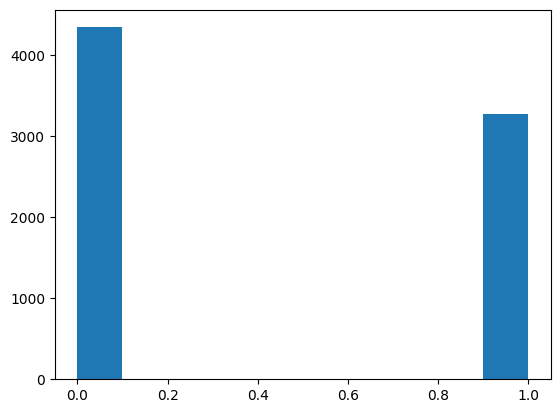

In [4]:
# How many are actually about disasters?
# What is the average length of each tweet? (in words)
# What are the most common keywords?

plt.hist(df_train['target'])
np.bincount(df_train['target'])

There are 3271 tweets about disasters out of 7613 total, which is 43%. Therefore the dataset is relatively balanced and I will not re-sample.

Text(0, 0.5, 'Tweet Count')

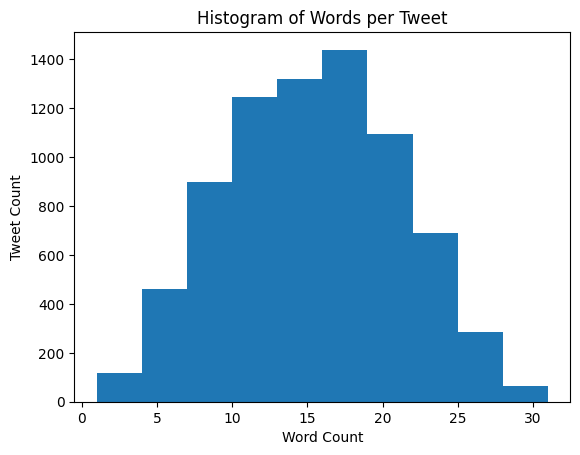

In [5]:
## Get number of words per tweet

tweet_lengths = []

for tweet in df_train['text']:
    ## Split each string on whitespace
    tweet_words = tweet.split()
    tweet_lengths.append(len(tweet_words))
    
    
plt.hist(tweet_lengths)
plt.title('Histogram of Words per Tweet')
plt.xlabel('Word Count')
plt.ylabel('Tweet Count')

The distribution of words per tweet is a surprisingly normal distribution around 15, with ranges between 0 and 30. 

**Keywords**

Below, I extracted the keywords and their frequencies in the training set. Fatalities is the #1 keyword, with threat and inundation towards the bottom.

In [9]:
df_train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

**Hashtags**

In [11]:
## Extract hashtags to see what people are talking about

def extract_hashtags(text):
    hashtags = re.findall(r'#(\w+)', text)
    return hashtags

In [14]:
# Test out function

print(df_train['text'][0])
extract_hashtags(df_train['text'][0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


['earthquake']

In [16]:
## Get hashtags from every row

df_train['hashtags'] = df_train['text'].apply(extract_hashtags)

df_train.head(10)

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]"
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,"[RockyFire, CAfire, wildfires]"
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,"[flood, disaster]"
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,[]
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,[]
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,[]


In [18]:
## Now I want to see the counts of different hashtags in the set:

hash_df = df_train['hashtags'].explode().reset_index(drop = True)
hash_df.value_counts()

hashtags
News        38
news        38
hot         31
best        30
prebreak    30
            ..
Suspense     1
Thriller     1
FREE         1
NewEP        1
LA           1
Name: count, Length: 2087, dtype: int64

I can see why 'News' would be the most used hashtag in a disaster tweets dataset. You can also imagine that some of the tweets containing #FREE or #Thriller may not actually be disasters.

### Data Preprocessing and Model Training

To process the tweets, I will need to remove punctuation, make everything lower case, and remove stop words. I am also going to split the training data and reserve a validation set to test without having to submit to Kaggle each time. Keras has a built-in text preprocessing layer that I will use. 

I am going to try using GRU first as that was the simpler RNN approach from the lectures and should be sufficient for short strings of text like tweets. Because the GRU layer requires an input shape, I will use the 'int' vectorizer so that I can specify the output sequence dimension.

For the first model I am using two back to back GRU layers, followed by 2 dense layers (ending with 2 output nodes) to return the probability of each class.

In [20]:
## Split into training and validation
train_df, val_df, train_lab, val_lab = train_test_split(df_train['text'], 
                                                        df_train['target'], 
                                                        test_size=0.30, 
                                                        random_state=42)

In [31]:
## Vectorize text

vectorizer = keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation',
                                         max_tokens = 1000,
                                         split='whitespace',
                                        output_mode = 'int',
                                        output_sequence_length = 20)

In [34]:
## Train vectorizer
vectorizer.adapt(train_df)

In [43]:
## Vectorize training and validation data

train_vec = vectorizer(train_df)

val_vec = vectorizer(val_df)

In [136]:
## Build an RNN model

model = keras.Sequential()

# Embed vectorized text into a dense vector, scaling down by 10x
model.add(keras.layers.Embedding(input_dim = 1000,  # size of dictionary
                                output_dim = 100,
                                input_length = 20))   # sequence length from vec

# GRU layer with 50 units
model.add(keras.layers.GRU(units = 50, 
                           input_shape = (10, 20, 100),
                          return_sequences = True))

# GRU layer with 10 units
model.add(keras.layers.GRU(units = 10))

# Dense layer with 2 nodes (0 or 1)
model.add(keras.layers.Dense(2))

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 20, 100)           100000    
                                                                 
 gru_30 (GRU)                (None, 20, 50)            22800     
                                                                 
 gru_31 (GRU)                (None, 10)                1860      
                                                                 
 dense_23 (Dense)            (None, 2)                 22        
                                                                 
Total params: 124682 (487.04 KB)
Trainable params: 124682 (487.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
## Compile and train

model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

model.save_weights('/kaggle/working/weights1.h5')

In [138]:
model.load_weights('/kaggle/working/weights1.h5')

hist1 = model.fit(x = train_vec,
         y = train_lab,
          batch_size = 75,
         validation_data = (val_vec, val_lab),
         epochs = 10)

Epoch 1/10
72/72 [==============================] - 7s 37ms/step - loss: 0.6439 - accuracy: 0.6189 - val_loss: 0.4982 - val_accuracy: 0.7658
Epoch 2/10
72/72 [==============================] - 2s 26ms/step - loss: 0.4428 - accuracy: 0.8005 - val_loss: 0.4702 - val_accuracy: 0.7824
Epoch 3/10
72/72 [==============================] - 2s 26ms/step - loss: 0.3997 - accuracy: 0.8260 - val_loss: 0.4630 - val_accuracy: 0.7947
Epoch 4/10
72/72 [==============================] - 2s 26ms/step - loss: 0.3731 - accuracy: 0.8418 - val_loss: 0.4709 - val_accuracy: 0.7933
Epoch 5/10
72/72 [==============================] - 2s 26ms/step - loss: 0.3592 - accuracy: 0.8531 - val_loss: 0.4782 - val_accuracy: 0.7890
Epoch 6/10
72/72 [==============================] - 2s 26ms/step - loss: 0.3417 - accuracy: 0.8615 - val_loss: 0.5049 - val_accuracy: 0.7785
Epoch 7/10
72/72 [==============================] - 2s 26ms/step - loss: 0.3276 - accuracy: 0.8701 - val_loss: 0.5028 - val_accuracy: 0.7912
Epoch 8/10
72

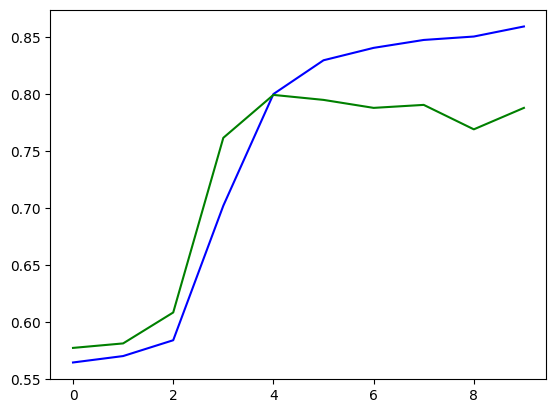

In [59]:
## Plot accuracies vs epoch

plt.plot(hist1.history['accuracy'], color = 'blue')
plt.plot(hist1.history['val_accuracy'], color = 'green')

**Tuning**

This model is clearly overfitting, as the training accuracy continues to increase while the validation accuracy plateaus. To combat the overfitting, I am going to reduce the batch size and rerun.

In [60]:
model.load_weights('/kaggle/working/weights1.h5')

hist2 = model.fit(x = train_vec,
         y = train_lab,
          batch_size = 25,
         validation_data = (val_vec, val_lab),
         epochs = 10)

Epoch 1/10
214/214 [==============================] - 5s 24ms/step - loss: 0.6806 - accuracy: 0.5742 - val_loss: 0.6714 - val_accuracy: 0.6016
Epoch 2/10
214/214 [==============================] - 5s 22ms/step - loss: 0.5444 - accuracy: 0.7086 - val_loss: 0.4722 - val_accuracy: 0.7898
Epoch 3/10
214/214 [==============================] - 5s 22ms/step - loss: 0.4248 - accuracy: 0.8092 - val_loss: 0.4614 - val_accuracy: 0.7995
Epoch 4/10
214/214 [==============================] - 5s 21ms/step - loss: 0.3889 - accuracy: 0.8304 - val_loss: 0.4568 - val_accuracy: 0.8008
Epoch 5/10
214/214 [==============================] - 5s 22ms/step - loss: 0.3635 - accuracy: 0.8429 - val_loss: 0.4715 - val_accuracy: 0.7990
Epoch 6/10
214/214 [==============================] - 5s 22ms/step - loss: 0.3388 - accuracy: 0.8604 - val_loss: 0.4963 - val_accuracy: 0.7824
Epoch 7/10
214/214 [==============================] - 5s 22ms/step - loss: 0.3126 - accuracy: 0.8701 - val_loss: 0.5115 - val_accuracy: 0.7877

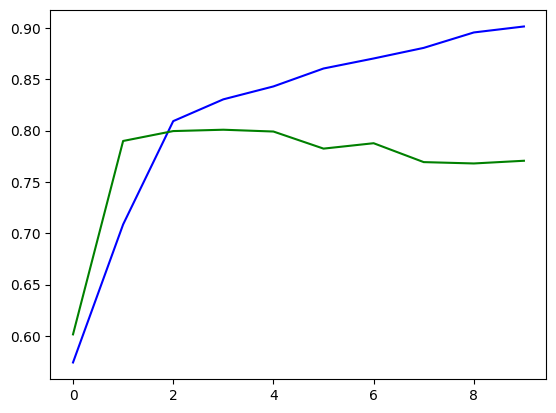

In [115]:
## Plot accuracies vs epoch

plt.plot(hist2.history['accuracy'], color = 'blue')
plt.plot(hist2.history['val_accuracy'], color = 'green')

I can see that the model continued to overfit, and was actually worse than the first model, so next I will try adding a dropout layer. The GRU layer comes with two built-in dropout variables, so I will set both to 0.2 to start.

In [61]:
model2 = keras.Sequential()


# Embed vectorized text into a dense vector, scaling down by 10x
model2.add(keras.layers.Embedding(input_dim = 1000,
                                output_dim = 100,
                                input_length = 20))

# GRU layer with 50 units
model2.add(keras.layers.GRU(units = 50, 
                           input_shape = (10, 20, 100),
                          return_sequences = True,
                           dropout = 0.2,
                           recurrent_dropout = 0.2,
                           seed = 42))

# GRU layer with 10 units
model2.add(keras.layers.GRU(units = 10,
                           dropout = 0.2,
                           recurrent_dropout = 0.2,
                           seed = 42))

# Dense layer with 2 nodes (0 or 1)
model2.add(keras.layers.Dense(2))

model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 20, 100)           100000    
                                                                 
 gru_18 (GRU)                (None, 20, 50)            22800     
                                                                 
 gru_19 (GRU)                (None, 10)                1860      
                                                                 
 dense_10 (Dense)            (None, 2)                 22        
                                                                 
Total params: 124682 (487.04 KB)
Trainable params: 124682 (487.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
## Compile and train like other keras models

model2.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

model2.save_weights('/kaggle/working/weights2.h5')

In [63]:
#model.load_weights('/kaggle/working/weights1.h5')

hist3 = model2.fit(x = train_vec,
         y = train_lab,
          batch_size = 25,
         validation_data = (val_vec, val_lab),
         epochs = 10)

Epoch 1/10
214/214 [==============================] - 13s 36ms/step - loss: 0.5978 - accuracy: 0.6613 - val_loss: 0.4726 - val_accuracy: 0.7942
Epoch 2/10
214/214 [==============================] - 7s 32ms/step - loss: 0.4356 - accuracy: 0.8086 - val_loss: 0.4737 - val_accuracy: 0.7868
Epoch 3/10
214/214 [==============================] - 7s 32ms/step - loss: 0.3995 - accuracy: 0.8221 - val_loss: 0.4685 - val_accuracy: 0.7929
Epoch 4/10
214/214 [==============================] - 7s 32ms/step - loss: 0.3812 - accuracy: 0.8343 - val_loss: 0.4665 - val_accuracy: 0.8017
Epoch 5/10
214/214 [==============================] - 7s 34ms/step - loss: 0.3594 - accuracy: 0.8499 - val_loss: 0.4697 - val_accuracy: 0.7955
Epoch 6/10
214/214 [==============================] - 7s 33ms/step - loss: 0.3407 - accuracy: 0.8666 - val_loss: 0.4771 - val_accuracy: 0.7942
Epoch 7/10
214/214 [==============================] - 7s 32ms/step - loss: 0.3223 - accuracy: 0.8688 - val_loss: 0.4997 - val_accuracy: 0.784

The validation accuracy is still hovering around 0.79 for each epoch, so I am thinking maybe there are too many features being input from the vectorizer / embedder. I am going to drop the output dimension of the embedder from 100 to 50. I will also remove the secondary GRU cell to see if that helps.

In [73]:
model3 = keras.Sequential()


# Embed vectorized text into a dense vector, scaling down by 20x
model3.add(keras.layers.Embedding(input_dim = 1000,
                                output_dim = 50,
                                input_length = 20))

# GRU layer with 50 units
model3.add(keras.layers.GRU(units = 50, 
                           input_shape = (10, 20, 50),
                          return_sequences = True,
                           dropout = 0.5,
                           recurrent_dropout = 0.5,
                           seed = 42))

# GRU layer with 10 units
# model3.add(keras.layers.GRU(units = 10,
#                            dropout = 0.2,
#                            recurrent_dropout = 0.2,
#                            seed = 42))

model3.add(keras.layers.Flatten())

# Dense layer with 2 nodes (0 or 1)
model3.add(keras.layers.Dense(2))

model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 20, 50)            50000     
                                                                 
 gru_24 (GRU)                (None, 20, 50)            15300     
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_14 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 67302 (262.90 KB)
Trainable params: 67302 (262.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
## Compile and train like other keras models

model3.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

model3.save_weights('/kaggle/working/weights3.h5')

In [75]:
hist4 = model3.fit(x = train_vec,
         y = train_lab,
          batch_size = 25,
         validation_data = (val_vec, val_lab),
         epochs = 10)

Epoch 1/10
214/214 [==============================] - 7s 20ms/step - loss: 0.5801 - accuracy: 0.6859 - val_loss: 0.4958 - val_accuracy: 0.7653
Epoch 2/10
214/214 [==============================] - 4s 17ms/step - loss: 0.4404 - accuracy: 0.8041 - val_loss: 0.4587 - val_accuracy: 0.7916
Epoch 3/10
214/214 [==============================] - 4s 19ms/step - loss: 0.4015 - accuracy: 0.8208 - val_loss: 0.4566 - val_accuracy: 0.7894
Epoch 4/10
214/214 [==============================] - 4s 18ms/step - loss: 0.3812 - accuracy: 0.8283 - val_loss: 0.4547 - val_accuracy: 0.7982
Epoch 5/10
214/214 [==============================] - 4s 18ms/step - loss: 0.3569 - accuracy: 0.8409 - val_loss: 0.4684 - val_accuracy: 0.7960
Epoch 6/10
214/214 [==============================] - 4s 18ms/step - loss: 0.3379 - accuracy: 0.8519 - val_loss: 0.4935 - val_accuracy: 0.7872
Epoch 7/10
214/214 [==============================] - 4s 18ms/step - loss: 0.3115 - accuracy: 0.8617 - val_loss: 0.4976 - val_accuracy: 0.7881

After trying many different ways of reducing the overfitting with the model's hyperparameters, I am going to try reducing the sequence length output by the vectorizer, as I don't want the model to fit on too many inconsequential words. I will reduce it from 20 to 7. I am also going to teach the vectorizer with the whole training set, rather than just the subset that was not reserved for validation.

In [128]:
# Second try at vectorization
vectorizer2 = keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation',
                                         max_tokens = 1000,
                                         split='whitespace',
                                        output_mode = 'int',
                                        output_sequence_length = 7)

vectorizer2.adapt(df_train['text'])

In [129]:
train_vec2 = vectorizer2(train_df)
val_vec2 = vectorizer2(val_df)

In [130]:
## Retry model 3, but need to update input shape

model4 = keras.Sequential()


# Embed vectorized text into a dense vector, scaling down by 20x
# Input length now 10 because of shorter sequence length output from vectorizer
model4.add(keras.layers.Embedding(input_dim = 1000,
                                output_dim = 50,
                                input_length = 7))

# GRU layer with 50 units
model4.add(keras.layers.GRU(units = 30, 
                           input_shape = (10, 7, 50),
                          return_sequences = True,
                           dropout = 0.5,
                           recurrent_dropout = 0.5,
                           seed = 42))

# GRU layer with 10 units
# model4.add(keras.layers.GRU(units = 10,
#                            dropout = 0.2,
#                            recurrent_dropout = 0.2,
#                            seed = 42))

model4.add(keras.layers.Flatten())

# Dense layer with 2 nodes (0 or 1)
model4.add(keras.layers.Dense(2))

model4.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 7, 50)             50000     
                                                                 
 gru_29 (GRU)                (None, 7, 30)             7380      
                                                                 
 flatten_8 (Flatten)         (None, 210)               0         
                                                                 
 dense_22 (Dense)            (None, 2)                 422       
                                                                 
Total params: 57802 (225.79 KB)
Trainable params: 57802 (225.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
model4.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

model4.save_weights('/kaggle/working/weights4.h5')

In [132]:
model4.load_weights('/kaggle/working/weights4.h5')
hist5 = model4.fit(x = train_vec2,
         y = train_lab,
          batch_size = 10,
         validation_data = (val_vec2, val_lab),
         epochs = 10)

Epoch 1/10
533/533 [==============================] - 9s 9ms/step - loss: 0.5809 - accuracy: 0.6868 - val_loss: 0.5099 - val_accuracy: 0.7513
Epoch 2/10
533/533 [==============================] - 4s 8ms/step - loss: 0.4657 - accuracy: 0.7799 - val_loss: 0.4988 - val_accuracy: 0.7644
Epoch 3/10
533/533 [==============================] - 4s 8ms/step - loss: 0.4336 - accuracy: 0.8013 - val_loss: 0.5063 - val_accuracy: 0.7605
Epoch 4/10
533/533 [==============================] - 4s 8ms/step - loss: 0.4051 - accuracy: 0.8103 - val_loss: 0.5265 - val_accuracy: 0.7566
Epoch 5/10
533/533 [==============================] - 4s 8ms/step - loss: 0.3865 - accuracy: 0.8210 - val_loss: 0.5372 - val_accuracy: 0.7566
Epoch 6/10
533/533 [==============================] - 4s 8ms/step - loss: 0.3598 - accuracy: 0.8366 - val_loss: 0.5701 - val_accuracy: 0.7570
Epoch 7/10
533/533 [==============================] - 4s 7ms/step - loss: 0.3374 - accuracy: 0.8452 - val_loss: 0.6034 - val_accuracy: 0.7469
Epoch 

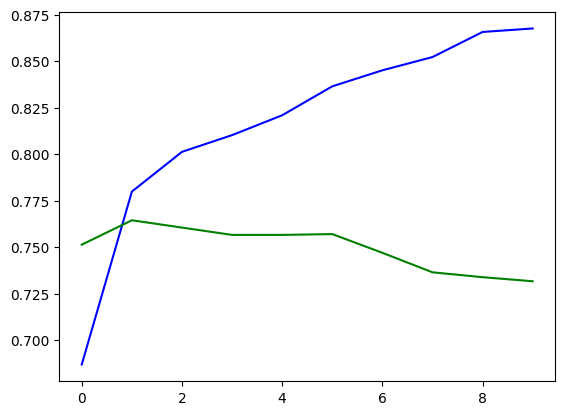

In [133]:
plt.plot(hist5.history['accuracy'], color = 'blue')
plt.plot(hist5.history['val_accuracy'], color = 'green')

### Results and Conclusion


After trying many different iterations of the RNN setup, I was not able to combat overfitting, and the first rendition appeared to have the best balance of training and test accuracies when truncated at 4 epochs.

|Model Number | Vectorizer | Architecture | Optimizer | Batch Size | Final Accuracies |
| ----------- | ---------- | -------------| --------- | ---------- | ---------------- |
| 1 | INT, SEQ = 20 | Embed(100), GRU(50), GRU(10), D(2) | Adam | 75 | 0.8591, 0.7877 |
| 2 | INT, SEQ = 20 | Embed(100), GRU(50), GRU(10), D(2) | Adam | 25 | 0.9013, 0.7706 |
| 3 | INT, SEQ = 20 | Embed(100), GRU(50, d/o), GRU(10, d/o), D(2) | Adam | 25 | 0.8975, 0.7750 |
| 4 | INT, SEQ = 20 | Embed(50), GRU(50), FLAT, D(2) | Adam | 25 | 0.8975, 0.7680 |
| 5 | INT, SEQ = 7 | Embed(50), GRU(50), FLAT, D(2) | Adam | 10 | 0.8677, 0.7316 |


At this point, I will use the first model and submit to Kaggle to receive a result.

In the future, I would be interested to see if the how adding n-grams would change the fit, and if there is a particular optimizer that is better suited to RNN structures that helps prevent overfitting. It is possible the dictionary could be limited further, and even adding in extra metadata like the keywords or hashtags.

In [140]:
## Retrain first model


model.load_weights('/kaggle/working/weights1.h5')

hist_final = model.fit(x = train_vec,
         y = train_lab,
          batch_size = 75,
         validation_data = (val_vec, val_lab),
         epochs = 10)

Epoch 1/10
72/72 [==============================] - 2s 26ms/step - loss: 0.6857 - accuracy: 0.5466 - val_loss: 0.6802 - val_accuracy: 0.5771
Epoch 2/10
72/72 [==============================] - 2s 26ms/step - loss: 0.6795 - accuracy: 0.5705 - val_loss: 0.6761 - val_accuracy: 0.5814
Epoch 3/10
72/72 [==============================] - 2s 26ms/step - loss: 0.6639 - accuracy: 0.6026 - val_loss: 0.6397 - val_accuracy: 0.6335
Epoch 4/10
72/72 [==============================] - 2s 26ms/step - loss: 0.5215 - accuracy: 0.7433 - val_loss: 0.4830 - val_accuracy: 0.7815
Epoch 5/10
72/72 [==============================] - 2s 27ms/step - loss: 0.4149 - accuracy: 0.8148 - val_loss: 0.4651 - val_accuracy: 0.7916
Epoch 6/10
72/72 [==============================] - 2s 26ms/step - loss: 0.3847 - accuracy: 0.8294 - val_loss: 0.4653 - val_accuracy: 0.7929
Epoch 7/10
72/72 [==============================] - 2s 30ms/step - loss: 0.3645 - accuracy: 0.8476 - val_loss: 0.4737 - val_accuracy: 0.8004
Epoch 8/10
72

In [141]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [143]:
test_vec = vectorizer(df_test['text'])

test_pred = np.argmax(model.predict(test_vec), axis = -1)

102/102 [==============================] - 1s 5ms/step


In [146]:
submission = pd.DataFrame(data = {'id' : df_test['id'],
                                 'target' : test_pred})

submission.to_csv('/kaggle/working/test_submission_disasters.csv', index = False)